In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split , GridSearchCV ,cross_val_predict
from sklearn.preprocessing import StandardScaler  
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge,LogisticRegression
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor


# I- Préparation de la base (voir R)

In [160]:
# Chargement des données

Gym = pd.read_csv("Donnees_projet.csv")

# Conversion des colonnes en catégories (équivalent à factor en R)
Gym['Gender'] = Gym['Gender'].astype('category')
Gym['Workout_Type'] = Gym['Workout_Type'].astype('category')
Gym['Workout_Frequency'] = Gym['Workout_Frequency (days/week)'].astype('category')
Gym['Experience_Level'] = Gym['Experience_Level'].astype('category')

# Renommage des colonnes pour simplifier l'accès
Gym['Session_Duration'] = Gym['Session_Duration (hours)']
Gym['Water_Intake'] = Gym['Water_Intake (liters)']

Gym["BMI"]=Gym["BMI"].map(lambda x: np.sqrt(x))

# Sélection des colonnes d'intérêt
Gym = Gym.iloc[:, [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 13, 14, 15, 16, 17]]

# Affichage des premières lignes et résumé statistique
print(Gym.head())
print(Gym.describe(include='all'))

GymDum=pd.get_dummies(Gym[["Gender","Workout_Type","Experience_Level","Workout_Frequency"]])
GymDum = GymDum.drop(columns=["Workout_Type_Cardio","Experience_Level_1","Workout_Frequency_2"])
GymQuant= Gym.select_dtypes(include=['int64', 'float64'])

   Age  Gender  Weight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM  \
0   56    Male         88.3        1.71      180      157           60   
1   46  Female         74.9        1.53      179      151           66   
2   32  Female         68.1        1.66      167      122           54   
3   25    Male         53.2        1.70      190      164           56   
4   38    Male         46.1        1.79      188      158           68   

   Calories_Burned Workout_Type  Fat_Percentage Experience_Level       BMI  \
0           1313.0         Yoga            12.6                3  5.495453   
1            883.0         HIIT            33.9                2  5.656854   
2            677.0       Cardio            33.4                2  4.970915   
3            532.0     Strength            28.8                1  4.290688   
4            556.0     Strength            29.2                1  3.793415   

  Workout_Frequency  Session_Duration  Water_Intake  
0                 4             

# II- Prévision des calories brûlées

Dans cette partie, nous avons pour objectif de prédire la quantitée de calories brûlées par rapport aux autres variables explicatives à notre disposition. Pour cela, nous allons tester plusieurs modèles et comparer leur efficacité. Pour la suite les variables explicatives qualitatives seront séparées en plusieurs variables par modalitées (par exemple Gender_female/ Gender_Male).

In [98]:
dfC=pd.concat([GymDum,GymQuant],axis=1)
dfC=dfC.drop(columns=["Calories_Burned"])
dfC.head()

,Gender_Female,Gender_Male,Workout_Type_HIIT,Workout_Type_Strength,Workout_Type_Yoga,Experience_Level_2,Experience_Level_3,Workout_Frequency_3,Workout_Frequency_4,Workout_Frequency_5,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Fat_Percentage,BMI,Session_Duration,Water_Intake
0,False,True,False,False,True,False,True,False,True,False,56,88.3,1.71,180,157,60,12.6,5.495453,1.69,3.5
1,True,False,True,False,False,True,False,False,True,False,46,74.9,1.53,179,151,66,33.9,5.656854,1.30,2.1
2,True,False,False,False,False,True,False,False,True,False,32,68.1,1.66,167,122,54,33.4,4.970915,1.11,2.3
3,False,True,False,True,False,False,False,True,False,False,25,53.2,1.70,190,164,56,28.8,4.290688,0.59,2.1
4,False,True,False,True,False,False,False,True,False,False,38,46.1,1.79,188,158,68,29.2,3.793415,0.64,2.8


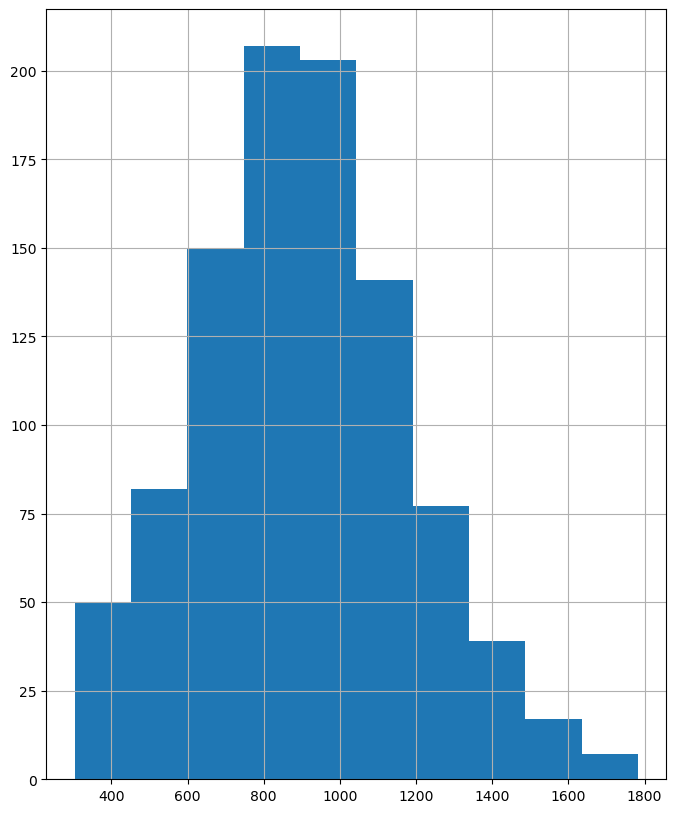

In [99]:
# variable à expliquer réelle
Y=Gym["Calories_Burned"]
Y.hist()
plt.show()

## 1) Séparation de la base en train/test

Avant de pouvoir réaliser nos différents modèle de prédiction, il est d'abord necessaire de séparer nos données en deux parties. La première partie correspond à 80% de la base complète. Elle permet d'entraîner un modèle sur les données qui lui sont fournies. La seconde partie est celle de test. Elle permettra d'appliquer notre modèle entraîné et de comparer les différentes méthodes entre elles.

In [100]:
X_train,X_test,Y_train,Y_test=train_test_split(dfC,Y,test_size=0.2,random_state=11)

In [101]:
# L'algorithme des réseaux de neurones nécessite éventuellement une normalisation 
# des variables explicatives avec les commandes ci-dessous
scaler = StandardScaler()  
scaler.fit(X_train)  
Xr_train = scaler.fit_transform(X_train)  
# Meme transformation sur le test
Xr_test = scaler.transform(X_test)

## 2)Modèle linéaire 


On s'interesse d'abord aux modèles de type linéaire. Ceux-ci sont vastement utilisés pour leur simplicité et interpretabilité.

### a)Sans Pénalisation

La variable à expliquer étant quantitative, on utilise un modèle de regression linéaire.

In [102]:
# Régression linéaire sans pénalisation
regLin = LinearRegression()

# Entraîner sur tout le train, prédire sur le test
regLin.fit(Xr_train, Y_train)
# Prédiction sur le train
PrevLR_train = regLin.predict(Xr_train)
# Prédiction sur les données de test
PrevLR = regLin.predict(Xr_test)
# Evaluation
r2_test= r2_score(Y_test, PrevLR)
r2_train= r2_score(Y_train, PrevLR_train)

n_train = len(Y_train)
n_test = len(Y_test)        # nombre d'observations
p = Xr_train.shape[1]  # nombre de variables explicatives (prédicteurs)

Q2 = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p - 1)
R2_ajuste = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p - 1)
mse_test = mean_squared_error(Y_test, PrevLR)
mse_train = mean_squared_error(Y_train, PrevLR_train)

print(f"R²-ajusté sur train = {R2_ajuste:.4f}")
print(f"Q² (R²-ajusté sur test) = {Q2:.4f}")
print(f"MSE sur test = {mse_test:.4f}")
print(f"MSE sur train = {mse_train:.4f}")

R²-ajusté sur train = 0.9782
Q² (R²-ajusté sur test) = 0.9791
MSE sur test = 1594.5484
MSE sur train = 1521.0900


Le R2 classique étant fortement élevé, on en déduit que ce modèle à un biais très faible.  Cependant, sans pénalisation, les modèles linéaires ont tendance à faire de l'overfitting pour un nombre de paramètres important. On se retrouve donc avec des modèles trop complexes. Cela se traduit par un R2 ajusté plus faible bien que très satsifaisant. Parla suite, on utilisera principalement la MSE étant une valeure sure pour comparer nos méthodes.

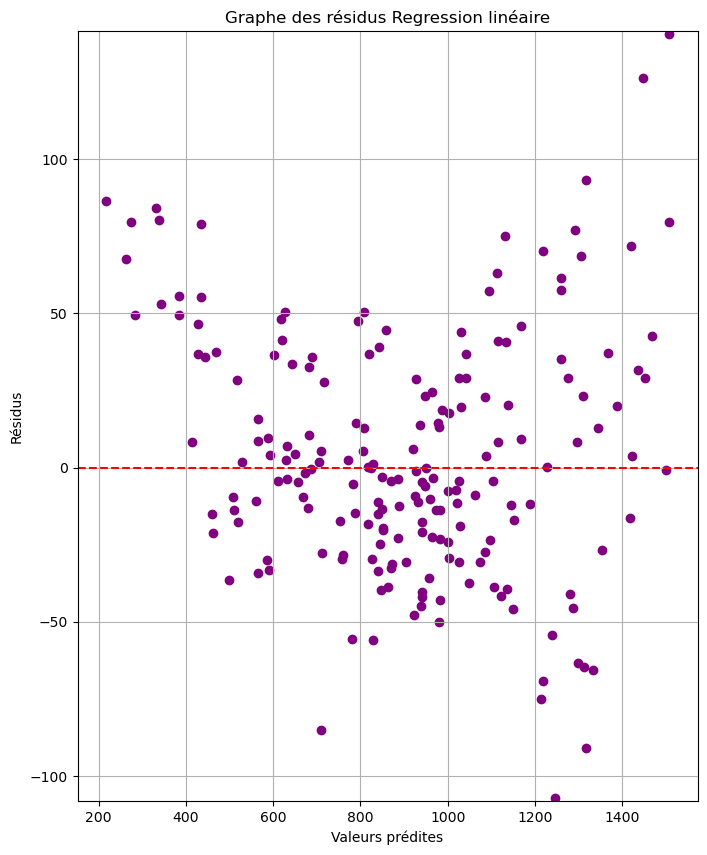

In [103]:
# Calcul des résidus
residusLR = Y_test - PrevLR

# Tracé du graphe des résidus
plt.scatter(PrevLR, residusLR, color='purple')
plt.axhline(y=0, color='red', linestyle='--')  # Ligne horizontale à y=0
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Graphe des résidus Regression linéaire")

plt.ylim(min(residusLR) - 1, max(residusLR) + 1) 
plt.grid(True)
plt.show()

En affichant le graphique des résidus on remarque une forme "en banane" synonyme d'un modèle peu fiable. En effet, si le modèle était bon nous observerions une ligne droit proche de la ligne y=0. Cela confirme que le modèle de régression linéaire sans pénalisation ni sélection de variable n'est pas très efficace pour la prédiction des calories brulées.

### b) Pénalisation

Il est necessaire de trouver un équilibre entre le biais et la variance. En effet dans certaines situation, il est préférable de chosisir un modèle biaisé qui permet de réduire de manière importante la variance que de choisir un modèle à R2 élevé. A cet effet, nous allons utiliser différents critères de pénalisation sur les modèles trop complexes.

#### i.  Sans selection de variable (Ridge)

In [71]:
regRidge = Ridge()

# Grille de valeurs pour alpha (la pénalisation)
alphas = np.linspace(0.01, 10, 100)
param = {'alpha': alphas}
regRidge = GridSearchCV(regRidge, param, cv=5, n_jobs=-1)
regRidgeOpt = regRidge.fit(Xr_train, Y_train)

# paramètre optimal
alpha_opt = regRidgeOpt.best_params_["alpha"]
print("Meilleur paramètre = %s" % (regRidgeOpt.best_params_))

Meilleur paramètre = {'alpha': 0.9181818181818182}


In [72]:
regRidge = Ridge(alpha=alpha_opt)

# Entraîner sur tout le train, prédire sur le test
regRidge.fit(Xr_train,Y_train)
PrevRidge=regRidge.predict(Xr_test)
PrevRidge_train=regRidge.predict(Xr_train)

# Evaluation
r2_test= r2_score(Y_test, PrevRidge)
r2_train= r2_score(Y_train, PrevRidge_train)

n_train = len(Y_train)
n_test = len(Y_test)        # nombre d'observations
p = Xr_train.shape[1]  # nombre de variables explicatives (prédicteurs)

Q2 = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p - 1)
R2_ajuste = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p - 1)
mse_test = mean_squared_error(Y_test, PrevRidge)
mse_train = mean_squared_error(Y_train, PrevRidge_train)

print(f"R²-ajusté sur train = {R2_ajuste:.4f}")
print(f"Q² (R²-ajusté sur test) = {Q2:.4f}")
print(f"MSE sur test = {mse_test:.4f}")
print(f"MSE sur train = {mse_train:.4f}")

R²-ajusté sur train = 0.9782
Q² (R²-ajusté sur test) = 0.9792
MSE sur test = 1589.2928
MSE sur train = 1521.6404


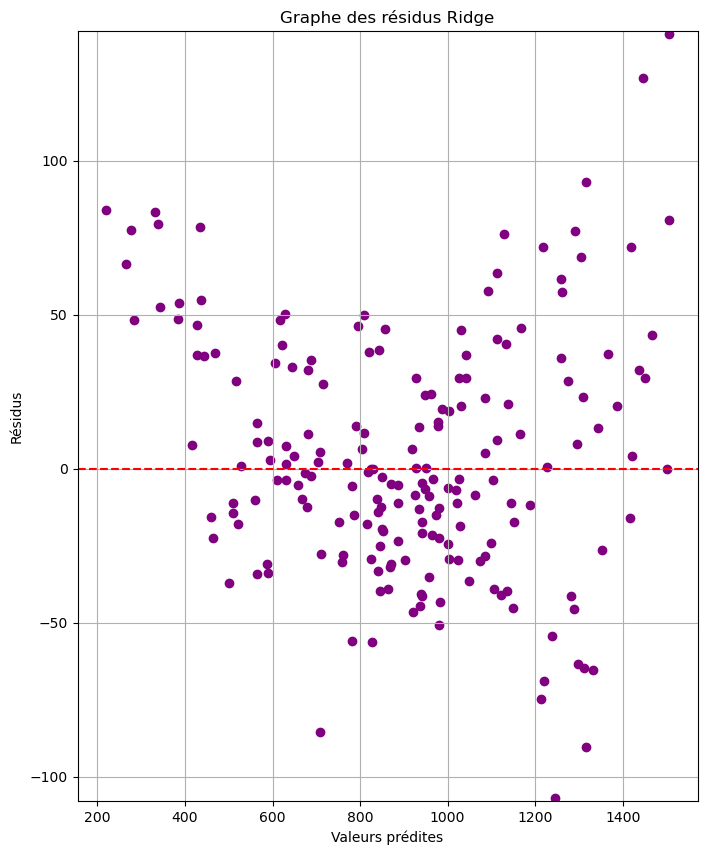

In [73]:
# Calcul des résidus
residusRidge = Y_test - PrevRidge

# Tracé du graphe des résidus
plt.scatter(PrevRidge, residusRidge, color='purple')
plt.axhline(y=0, color='red', linestyle='--')  # Ligne horizontale à y=0
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Graphe des résidus Ridge")

plt.ylim(min(residusRidge) - 1, max(residusRidge) + 1) 
plt.grid(True)
plt.show()

#### ii. Avec sélection de variable (Cp/AIC/BIC et Lasso)

**LASSO**

Pour faire la pénalisation LASSO, On réalise d'abord une cross validation qui nous indique le lambda optimal. En python, la validation croisée est réalisée par GridSearchCV.

In [74]:
# grille de valeurs du paramètre alpha à optimiser
param=[{"alpha":np.linspace(0.05, 5, 30) }]
regLasso = GridSearchCV(linear_model.Lasso(), param,cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(Xr_train, Y_train)
# paramètre optimal
alpha_opt = regLassOpt.best_params_["alpha"]
print("Meilleur paramètre = %s" % (regLassOpt.best_params_))

Meilleur paramètre = {'alpha': 1.2448275862068967}


Une fois le lambda réalisé on peut l'afficher sur les regularization paths (en R) pour voir les variables conservées par l'algorithme LASSO. En python, nous sommes obligé de reréaliser l'ajustement du modèle car GridSearchCV ne permet pas de garder les coefficients du modèles. Pour l'analyse nous avons donc besoin d'utiliser linear_model.Lasso directement.

Lasso conserve 11 variables et en supprime 9


Text(0.5, 1.0, 'Coefficients du modèle lasso')

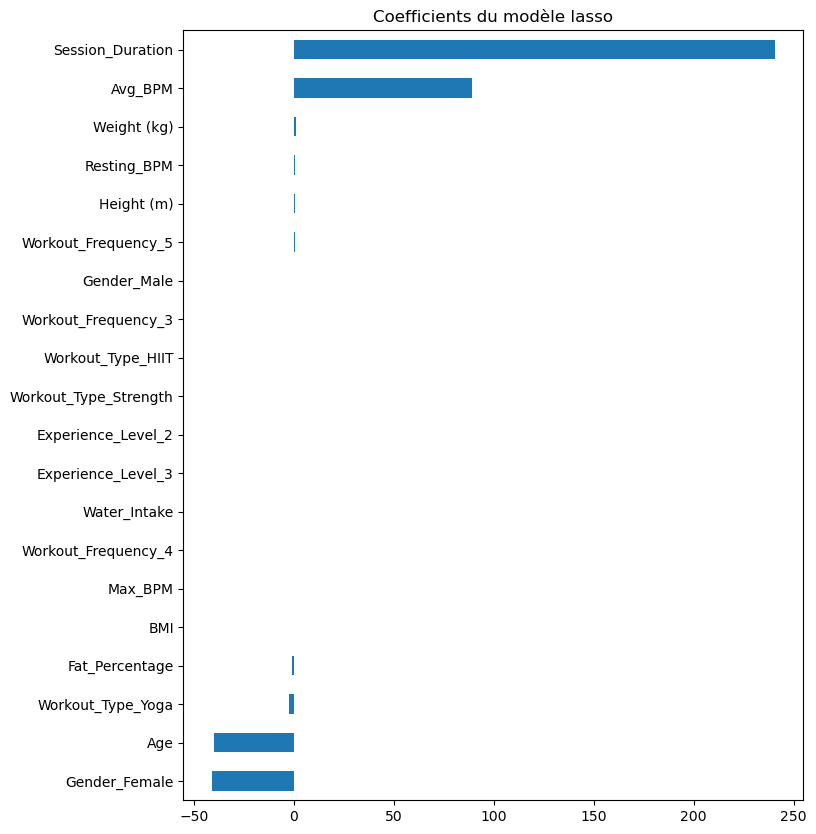

In [75]:
regLasso=linear_model.Lasso(alpha=regLassOpt.best_params_['alpha'])

# Entraîner sur tout le train, prédire sur le test
model_lasso=regLasso.fit(Xr_train,Y_train)
PrevLasso=regLasso.predict(Xr_test)
PrevLasso_train=regLassOpt.predict(Xr_train)

coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso")

D'apres ce critère, les variables les plus interessantes pour prédire les carolies brûlées sont la durée de la session, le BPM moyen, le genre (Pour éviter les redondances, la modalitée princiaple gardée est le sexe féminin) et l'âge.

In [76]:
# Evaluation
r2_test= r2_score(Y_test, PrevLasso)
r2_train= r2_score(Y_train, PrevLasso_train)

n_train = len(Y_train)
n_test = len(Y_test)        # nombre d'observations
p = sum(coef != 0)  # nombre de variables explicatives (prédicteurs)

Q2 = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p - 1)
R2_ajuste = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p - 1)
mse_test = mean_squared_error(Y_test, PrevLasso)
mse_train = mean_squared_error(Y_train, PrevLasso_train)

print(f"R²-ajusté sur train = {R2_ajuste:.4f}")
print(f"Q² (R²-ajusté sur test) = {Q2:.4f}")
print(f"MSE sur test = {mse_test:.4f}")
print(f"MSE sur train = {mse_train:.4f}")

R²-ajusté sur train = 0.9780
Q² (R²-ajusté sur test) = 0.9803
MSE sur test = 1585.5329
MSE sur train = 1550.8393


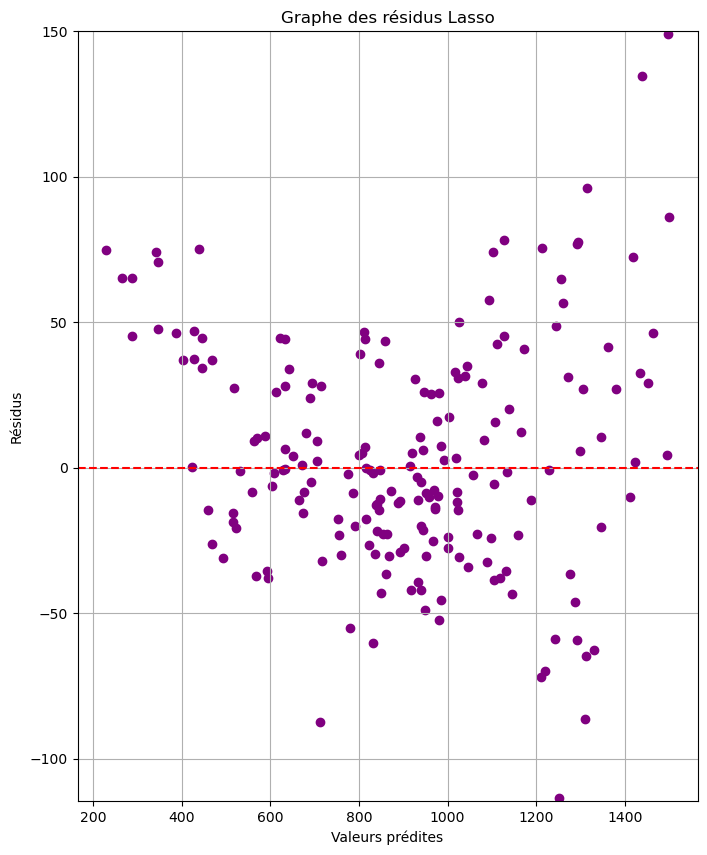

In [77]:
# Calcul des résidus
residusLasso = Y_test - PrevLasso

# Tracé du graphe des résidus
plt.scatter(PrevLasso, residusLasso, color='purple')
plt.axhline(y=0, color='red', linestyle='--')  # Ligne horizontale à y=0
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Graphe des résidus Lasso")

plt.ylim(min(residusLasso) - 1, max(residusLasso) + 1) 
plt.grid(True)
plt.show()

Pour l'instant cette pénalisation semble pas avoir beaucoup d'effet. Bizarre que MSE diff de celle en R.

**Cp/AIC/BIC**

En python, il n'est pas possible d'utiliser ces méthodes de sélection de variable. En effet, sklearn ne propose pas directement de sélection par AIC. Nous nous refererons donc à notre notebook R pour cette méthode.

### c) Comparaison des modèles

Attention pour comparer les modèles il ne faut pas utiliser R2(echantillon train) mais Q2(sur échantillon test)!!

## 3) Support vector regression

In [78]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.1, 1, 10, 100],
    "epsilon": [0.01, 0.1, 0.5],
    "kernel": ["rbf"],
    "gamma": ["scale", 0.01, 0.02, 0.1, 1]
}

#param=[{"C":[0.4,0.5,0.6,0.8,1,1.4, 1.8]}]
svm= GridSearchCV(SVR(),param_grid,cv=10,n_jobs=-1)
svmOpt=svm.fit(Xr_train, Y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - svmOpt.best_score_,svmOpt.best_params_))

Meilleur score = 0.022674, Meilleur paramètre = {'C': 100, 'epsilon': 0.5, 'gamma': 0.02, 'kernel': 'rbf'}


In [79]:
# erreur de prévision sur le test
1-svmOpt.score(Xr_test,Y_test)

0.014357142366811182

In [80]:
print("Score Q^2 :", svmOpt.score(Xr_test, Y_test))

Score Q^2 : 0.9856428576331888


## 4) Arbre Optimal

In [81]:
# Optimisation de la profondeur de l'arbre pour un problème de régression
param = [{"max_depth": list(range(2, 10))}]
tree = GridSearchCV(DecisionTreeRegressor(), param, cv=10, n_jobs=-1)
treeOpt = tree.fit(Xr_train, Y_train)

# Affichage du meilleur score (R² ici) et du meilleur paramètre
print("Meilleur score (R²) = %f, Meilleur paramètre = %s" % (treeOpt.best_score_, treeOpt.best_params_))

Meilleur score (R²) = 0.921276, Meilleur paramètre = {'max_depth': 8}


In [82]:
# Estimation de l'erreur de prévision
1-treeOpt.score(Xr_test,Y_test)

0.0664098592895781

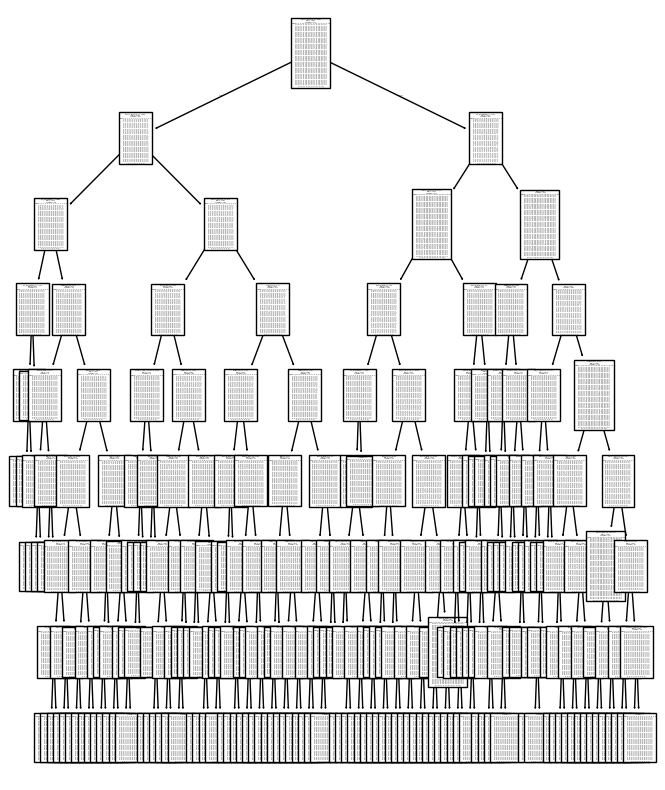

In [83]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

treeG=DecisionTreeClassifier(max_depth=treeOpt.best_params_['max_depth'])
treeG.fit(Xr_train,Y_train)
plot_tree(treeG,feature_names=dfC.columns.tolist());
plt.show()

## 5) Forêt aléatoire

In [84]:
from sklearn.ensemble import RandomForestClassifier 
# définition des paramètres
forest = RandomForestClassifier(n_estimators=500, 
   criterion='gini', max_depth=None,
   min_samples_split=2, min_samples_leaf=1, 
   max_features='sqrt', max_leaf_nodes=None,
   bootstrap=True, oob_score=True)
# apprentissage
rfFit = forest.fit(Xr_train,Y_train)
print(1-rfFit.oob_score_)

0.9948586118251928


In [85]:
# erreur de prévision sur le test
1-rfFit.score(Xr_test,Y_test)

0.9897435897435898

c'est bizarre qu'on ait un truc si proche de 1 parce que ça veut dire que l'erreur est énorme ...

In [86]:
param=[{"max_features":list(range(2,10,1))}]
rf= GridSearchCV(RandomForestClassifier(n_estimators=100),
        param,cv=5,n_jobs=-1)
rfOpt=rf.fit(Xr_train, Y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Meilleur score = 0.993581, Meilleur paramètre = {'max_features': 6}


In [87]:
# erreur de prévision sur le test
1-rfOpt.score(Xr_test,Y_test)

0.9948717948717949

## 6) Boosting

## 7) Réseaux de neuronnes

# III- Prévision du niveau d'experience

In [137]:
GymDum=pd.get_dummies(Gym[["Gender","Workout_Type","Experience_Level","Workout_Frequency"]])
GymDum = GymDum.drop(columns=["Workout_Type_Cardio","Workout_Frequency_2"])
GymDum.head()

Y1=GymDum["Experience_Level_1"]
Y2=GymDum["Experience_Level_2"]
Y3=GymDum["Experience_Level_3"]

Y1.head()

0    False
1    False
2    False
3     True
4     True
Name: Experience_Level_1, dtype: bool

In [138]:
dfC2=pd.concat([GymDum,GymQuant],axis=1)
dfC2=dfC2.drop(columns=["Experience_Level_1","Experience_Level_2", "Experience_Level_3"]) 
dfC2.head()

,Gender_Female,Gender_Male,Workout_Type_HIIT,Workout_Type_Strength,Workout_Type_Yoga,Workout_Frequency_3,Workout_Frequency_4,Workout_Frequency_5,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Calories_Burned,Fat_Percentage,BMI,Session_Duration,Water_Intake
0,False,True,False,False,True,False,True,False,56,88.3,1.71,180,157,60,1313.0,12.6,5.495453,1.69,3.5
1,True,False,True,False,False,False,True,False,46,74.9,1.53,179,151,66,883.0,33.9,5.656854,1.30,2.1
2,True,False,False,False,False,False,True,False,32,68.1,1.66,167,122,54,677.0,33.4,4.970915,1.11,2.3
3,False,True,False,True,False,True,False,False,25,53.2,1.70,190,164,56,532.0,28.8,4.290688,0.59,2.1
4,False,True,False,True,False,True,False,False,38,46.1,1.79,188,158,68,556.0,29.2,3.793415,0.64,2.8


## 1) Séparation de la base en train/test

In [140]:
X1_train,X1_test,Y1_train,Y1_test=train_test_split(dfC2,Y1,test_size=0.2,random_state=11)
X2_train,X2_test,Y2_train,Y2_test=train_test_split(dfC2,Y2,test_size=0.2,random_state=11)
X3_train,X3_test,Y3_train,Y3_test=train_test_split(dfC2,Y3,test_size=0.2,random_state=11)

In [141]:
# L'algorithme des réseaux de neurones nécessite éventuellement une normalisation 
# des variables explicatives avec les commandes ci-dessous
scaler = StandardScaler()  
scaler.fit(Xq_train)  
Xb1_train = scaler.fit_transform(X1_train)  
Xb1_test = scaler.transform(X1_test)
Xb2_train = scaler.fit_transform(X2_train)  
Xb2_test = scaler.transform(X2_test)
Xb3_train = scaler.fit_transform(X3_train)  
Xb3_test = scaler.transform(X3_test)

## 2) Modèle linéaire

### i. Regression logistique

#### a) Niveau 1 d'Expérience Level

In [142]:
# Optimisation du paramètre de pénalisation
# grille de valeurs
param=[{"C":[1,1.2,1.5,1.7,2,3,4]}]
logit = GridSearchCV(LogisticRegression(penalty="l1",solver="liblinear"), param,cv=5,n_jobs=-1)
logitOpt=logit.fit(Xb1_train, Y1_train)  # GridSearchCV est lui-même un estimateur
# paramètre optimal
logitOpt.best_params_["C"]
print("Meilleur score = %f, Meilleur paramètre = %s" % (1.-logitOpt.best_score_,logitOpt.best_params_))

Meilleur score = 0.124673, Meilleur paramètre = {'C': 1.2}


In [144]:
# erreur sur l'échantillon test
1-logitOpt.score(Xb1_test, Y1_test)

0.1282051282051282

In [147]:
# Prévision
y_chap1 = logitOpt.predict(Xb1_test)
# matrice de confusion
table=pd.crosstab(y_chap1,Y1_test)
print(table)

accuracy = np.trace(table.values) / table.values.sum()
print("Accuracy:", accuracy)

Experience_Level_1  False  True 
row_0                           
False                 105     13
True                   12     65
Accuracy: 0.8717948717948718


L’objectif est de prédire si un utilisateur appartient au niveau d’expérience 1 à l’aide d’un modèle de classification binaire. On évalue la performance du modèle à l’aide d’une matrice de confusion, avec les résultats suivants :

Vrais positifs (TP) : 65 \
Faux positifs (FP) : 13\
Faux négatifs (FN) : 12\
Vrais négatifs (TN) : 105

Le taux de validité de cette matrice de confusion étant de 0,87, nous pouvons considérer que le modèle sait bien prédire les individus ayant un niveau d'expérience égal à 1. 


In [148]:
# Coefficients
logitLasso=LogisticRegression(penalty="l1",C=logitOpt.best_params_['C'],
                              solver="liblinear")
logitCoef=logitLasso.fit(Xb1_train,Y1_train).coef_
print(logitCoef[0])


[ 0.00000000e+00 -7.83968153e-02  0.00000000e+00  4.75146735e-02
 -1.78844410e-01 -2.66508659e+00 -5.10773948e+00 -2.47991107e+00
  2.36564941e-02  0.00000000e+00  6.23411158e-02 -7.10867140e-02
  2.23711483e-01 -1.10615240e-01 -9.59050528e-01  4.47993215e-02
 -3.63191193e-03 -7.55113333e-01  8.68316038e-02]


In [149]:
coef = pd.Series(logitCoef[0], index = X1_train.columns)
print("Lasso conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))

Lasso conserve 16 variables et en supprime 3


In [150]:
coef_df = pd.Series(logitCoef[0], index=X1_train.columns)
print(coef_df)
print("Variables avec coefficient nul (éliminées par Lasso) :")
print(coef_df[coef_df == 0])

Gender_Female            0.000000
Gender_Male             -0.078397
Workout_Type_HIIT        0.000000
Workout_Type_Strength    0.047515
Workout_Type_Yoga       -0.178844
Workout_Frequency_3     -2.665087
Workout_Frequency_4     -5.107739
Workout_Frequency_5     -2.479911
Age                      0.023656
Weight (kg)              0.000000
Height (m)               0.062341
Max_BPM                 -0.071087
Avg_BPM                  0.223711
Resting_BPM             -0.110615
Calories_Burned         -0.959051
Fat_Percentage           0.044799
BMI                     -0.003632
Session_Duration        -0.755113
Water_Intake             0.086832
dtype: float64
Variables avec coefficient nul (éliminées par Lasso) :
Gender_Female        0.0
Workout_Type_HIIT    0.0
Weight (kg)          0.0
dtype: float64


Text(0.5, 1.0, 'Coefficients du modèle lasso')

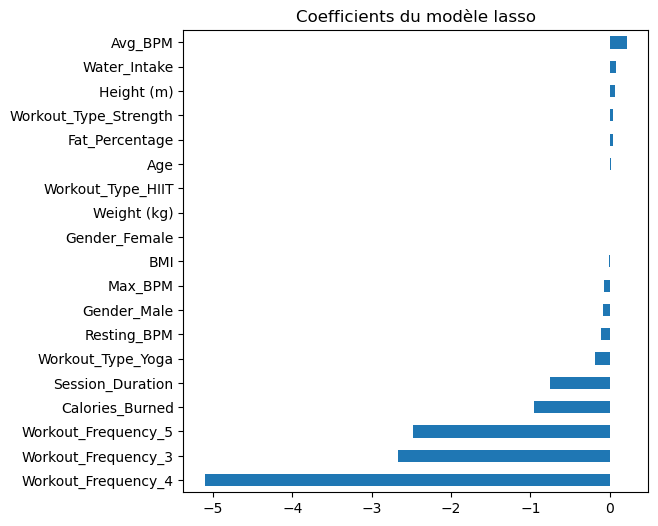

In [151]:
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso")

Les variables Workout_Type_HIIT, Weight (kg) et Gender_female ont un coefficient nul, ce qui signifie que le modèle ne les considère pas comme informatives pour la prédiction, compte tenu des autres variables disponibles. Ces variables sont donc éliminées automatiquement par la régularisation L1. Cela peut signifier qu’elles n’apportent pas d'information discriminante une fois les autres variables prises en compte, ou qu’elles sont corrélées à d'autres variables déjà présentes. 
    De plus, certaines variables ont un coéfficient important par rapport à d'autres, c'est le cas par exemple de Workout_Frequency_4 qui a un coefficient de -5.10. Cela siginifie que s’entraîner 4 fois par semaine est fortement négatif pour le niveau 1 d'Expérience_Level. Ainsi, Le modèle suggère la fréquence d’entraînement élevée ou modérée (3 à 5 fois par semaine) est négativement associée à la probabilité d’appartenir au niveau 1. Le niveau 1 représentant des débutants, cette analyse est logique en effet, un débutant ne va pas s'entraîner beaucoup au début ainsi une personne qui s'entraîne entre 3 et 5 fois par semaine a peu de chances d'être un débutant. 
     De même, la durée de la session ainsi que le nombre de calories brulées ont un coefficient négatif car elles sont généralement associées à des niveaux plus experimentés.  

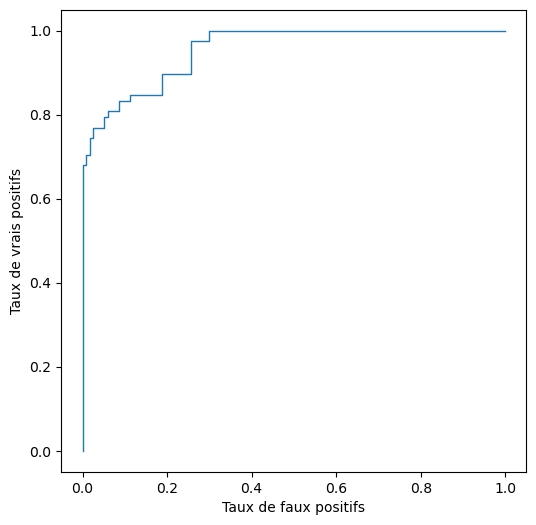

In [161]:
from sklearn.metrics import roc_curve
probas_ = LogisticRegression(penalty="l1", solver="liblinear",
                    C=logitOpt.best_params_['C']).fit(X1_train, Y1_train).predict_proba(X1_test)
fpr, tpr, thresholds = roc_curve(Y1_test, probas_[:,1])
plt.plot(fpr, tpr, lw=1)
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.show()

#### b) Niveau 2 d'Expérience Level

In [162]:
# Optimisation du paramètre de pénalisation
# grille de valeurs
param=[{"C":[1,1.2,1.5,1.7,2,3,4]}]
logit = GridSearchCV(LogisticRegression(penalty="l1",solver="liblinear"), param,cv=5,n_jobs=-1)
logitOpt=logit.fit(Xb2_train, Y2_train)  # GridSearchCV est lui-même un estimateur
# paramètre optimal
logitOpt.best_params_["C"]
print("Meilleur score = %f, Meilleur paramètre = %s" % (1.-logitOpt.best_score_,logitOpt.best_params_))

Meilleur score = 0.167047, Meilleur paramètre = {'C': 1}


In [163]:
# erreur sur l'échantillon test
1-logitOpt.score(Xb2_test, Y2_test)

0.16410256410256407

In [164]:
# Prévision
y_chap2 = logitOpt.predict(Xb2_test)
# matrice de confusion
table=pd.crosstab(y_chap2,Y2_test)
print(table)

accuracy = np.trace(table.values) / table.values.sum()
print("Accuracy:", accuracy)

Experience_Level_2  False  True 
row_0                           
False                 104     17
True                   15     59
Accuracy: 0.8358974358974359


In [166]:
# Coefficients
logitLasso=LogisticRegression(penalty="l1",C=logitOpt.best_params_['C'],
                              solver="liblinear")
logitCoef=logitLasso.fit(Xb2_train,Y2_train).coef_
print(logitCoef[0])


[-0.48842471  0.90014583  0.01197848 -0.10025576  0.06523506  2.52569406
  3.57784287  0.          0.          0.         -0.06639776  0.03247831
  0.          0.00909491  0.44935911  1.95897556  0.01446353  0.19127314
 -0.74433726]


In [167]:
coef = pd.Series(logitCoef[0], index = X2_train.columns)
print("Lasso conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))

Lasso conserve 15 variables et en supprime 4


In [168]:
coef_df = pd.Series(logitCoef[0], index=X2_train.columns)
print(coef_df)
print("Variables avec coefficient nul (éliminées par Lasso) :")
print(coef_df[coef_df == 0])

Gender_Female           -0.488425
Gender_Male              0.900146
Workout_Type_HIIT        0.011978
Workout_Type_Strength   -0.100256
Workout_Type_Yoga        0.065235
Workout_Frequency_3      2.525694
Workout_Frequency_4      3.577843
Workout_Frequency_5      0.000000
Age                      0.000000
Weight (kg)              0.000000
Height (m)              -0.066398
Max_BPM                  0.032478
Avg_BPM                  0.000000
Resting_BPM              0.009095
Calories_Burned          0.449359
Fat_Percentage           1.958976
BMI                      0.014464
Session_Duration         0.191273
Water_Intake            -0.744337
dtype: float64
Variables avec coefficient nul (éliminées par Lasso) :
Workout_Frequency_5    0.0
Age                    0.0
Weight (kg)            0.0
Avg_BPM                0.0
dtype: float64


Text(0.5, 1.0, 'Coefficients du modèle lasso')

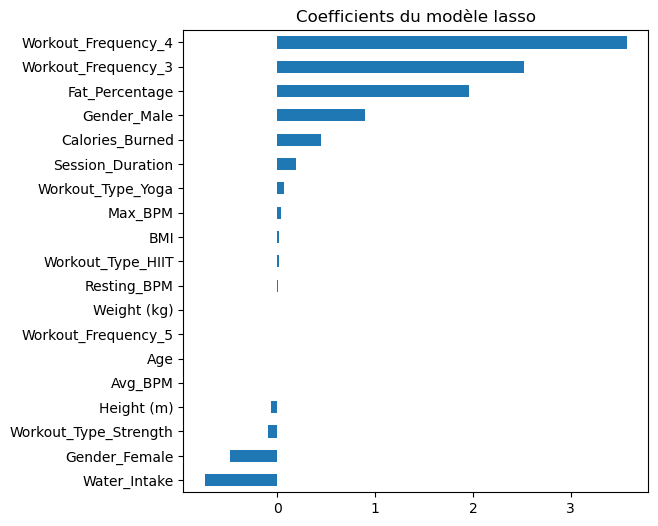

In [169]:
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso")

#### c) Niveau 3 d'Expérience Level

In [171]:
# Optimisation du paramètre de pénalisation
# grille de valeurs
param=[{"C":[1,1.2,1.5,1.7,2,3,4]}]
logit = GridSearchCV(LogisticRegression(penalty="l1",solver="liblinear"), param,cv=5,n_jobs=-1)
logitOpt=logit.fit(Xb3_train, Y3_train)  # GridSearchCV est lui-même un estimateur
# paramètre optimal
logitOpt.best_params_["C"]
print("Meilleur score = %f, Meilleur paramètre = %s" % (1.-logitOpt.best_score_,logitOpt.best_params_))

Meilleur score = 0.000000, Meilleur paramètre = {'C': 1}


In [172]:
# erreur sur l'échantillon test
1-logitOpt.score(Xb3_test, Y3_test)

0.0

In [173]:
# Prévision
y_chap3 = logitOpt.predict(Xb3_test)
# matrice de confusion
table=pd.crosstab(y_chap3,Y3_test)
print(table)

accuracy = np.trace(table.values) / table.values.sum()
print("Accuracy:", accuracy)

Experience_Level_3  False  True 
row_0                           
False                 154      0
True                    0     41
Accuracy: 1.0


In [189]:
# Coefficients
logitLasso=LogisticRegression(penalty="l1",C=logitOpt.best_params_['C'],
                              solver="liblinear")
logitCoef=logitLasso.fit(Xb3_train,Y3_train).coef_
print(logitCoef[0])
coef = pd.Series(logitCoef[0], index = X3_train.columns)
print("Lasso conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))

[ 0.70922819 -0.78755606  0.          0.          0.         -0.20784678
  0.03760357  0.49691145  0.          0.          0.          0.
  0.          0.          0.         -4.46223102  0.          2.090185
  0.01718983]
Lasso conserve 8 variables et en supprime 11


In [190]:
coef_df3 = pd.Series(logitCoef[0], index=X3_train.columns)
print(coef_df3)
print("Variables avec coefficient nul (éliminées par Lasso) :")
print(coef_df3[coef_df3 == 0])

Gender_Female            0.709228
Gender_Male             -0.787556
Workout_Type_HIIT        0.000000
Workout_Type_Strength    0.000000
Workout_Type_Yoga        0.000000
Workout_Frequency_3     -0.207847
Workout_Frequency_4      0.037604
Workout_Frequency_5      0.496911
Age                      0.000000
Weight (kg)              0.000000
Height (m)               0.000000
Max_BPM                  0.000000
Avg_BPM                  0.000000
Resting_BPM              0.000000
Calories_Burned          0.000000
Fat_Percentage          -4.462231
BMI                      0.000000
Session_Duration         2.090185
Water_Intake             0.017190
dtype: float64
Variables avec coefficient nul (éliminées par Lasso) :
Workout_Type_HIIT        0.0
Workout_Type_Strength    0.0
Workout_Type_Yoga        0.0
Age                      0.0
Weight (kg)              0.0
Height (m)               0.0
Max_BPM                  0.0
Avg_BPM                  0.0
Resting_BPM              0.0
Calories_Burned        

Text(0.5, 1.0, 'Coefficients du modèle lasso')

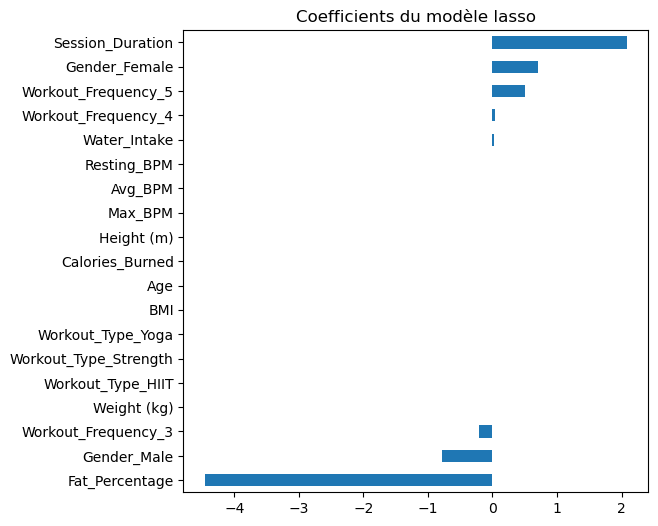

In [191]:
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso")

### ii. LSVM

## 3)SVR/SVM

## 4) Arbre optimal CART

## 5) Forêt aléatoire

## 6) Boosting

## 7) Réseaux de neuronne